<a href="https://colab.research.google.com/github/belyakovmy/pet-projects/blob/main/%D0%9A%D0%BE%D0%B3%D0%BE%D1%80%D1%82%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##О когортном анализе

Когортный анализ — это разновидность анализа, во время которого мы делим пользователей на группы, когорты, и анализируем поведение каждой когорты в отдельности. Когорты обычно выделяют по признаку времени — то есть смотрят, когда конкретно люди совершили то или иное действие.

Как раз привязка ко времени отличает когорту от сегмента:
* При анализе когорт мы смотрим, как ведут себя пользователя с разными характеристиками, но совершившими одно и то же действие в одно и то же время.
* При анализе сегментов смотрим на пользователей со схожими характеристиками, которые совершали разные действия в разное время.

Это помогает видеть более полную картину изменения метрик, эффективности маркетинговых мероприятий, помогает бизнесу корректировать стратегии.

Для проведения когортного анализа необходимо определить:  
* Признак когорты: действие для включения в группу(например, первый заказ или регистрация).
* Размер когорты: период, в течение которого будем формировать когорту.
* Длительность анализа когорты.
* Метрика для анализа.

##Структура данных

Это искусственный набор данных, содержащий транзакции онлайн-магазина в период с 01.12.2010 по 09.12.2011.

- InvoiceNo: номер чека.
- StockCode: код товара.
- Description: описание/наименование товара.
- Quantity: количество позиций в заказе.
- InvoiceDate: дата заказа.
- UnitPrice: цена единицы товара.
- CustomerID: номер клиента.
- Country: название страны, откуда был заказ.

##Цель исследования
Выполнить когортный анализ для двух метрик:   
 * Retention:  
Оценим, насколько хорошо продукт удерживает пользователей: какие когорты имею более высокое или низкое удержание.
В какой месяц происходит наибольший отток.

```
Признак включения в когорту: первая транзация пользователя.  
Размер когорты: 1 месяц.  
Длительность: в течение года в период с 01.12.2010 по 01.12.2011.
```
* LTV:  
Оценим, сколько денег в среднем приносит пользователь из каждой когорты за время взаимодействия с продуктом.
Какие когорты самые выгодные.


```

Признак включения в когорту: первая транзация пользователя.  
Размер когорты: 1 месяц.  
Длительность: в течение года в период с 01.12.2010 по 01.12.2011. Метику будем замерять через 30, 60, 90, 180, 300, 400 дней.  

```


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from duckdb import query

In [ ]:
url = 'https://media.githubusercontent.com/media/belyakovmy/pet-projects/refs/heads/main/datasets/OnlineRetail.csv'
data = pd.read_csv(url, encoding='ISO-8859-1')

In [ ]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [ ]:
data[data['Description'].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01-12-2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,01-12-2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,01-12-2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,01-12-2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,01-12-2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,07-12-2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,07-12-2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,07-12-2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,08-12-2011 10:33,0.0,NaN,United Kingdom


Нам не нужно поле Description, поэтому отсутствующие данные там можно было бы оставить, но, как оказалось, если нет указано поле Description, то нет и CustomerID, поэтому удаляем все пропуски:

In [ ]:
data = data.dropna()

Есть дубликаты:

In [ ]:
data.duplicated().sum()

np.int64(5225)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True)

In [ ]:
data['CustomerID'] = data['CustomerID'].astype('int64').astype('str')

In [ ]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,401604.000000,401604,401604.000000
mean,12.183273,2011-07-10 12:08:23.848567552,3.474064
min,-80995.000000,2010-12-01 08:26:00,0.000000
25%,2.000000,2011-04-06 15:02:00,1.250000
50%,5.000000,2011-07-29 15:40:00,1.950000
75%,12.000000,2011-10-20 11:58:30,3.750000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,250.283037,NaN,69.764035


Есть записи, где количество проданных товаров отрицательное, а цена за единицу товара равна 0 - это похоже на ошибки в данных, не будем учитывать эти записи.

In [ ]:
data = data.query('Quantity>0 & UnitPrice>0')

In [ ]:
data.describe()

,Quantity,InvoiceDate,UnitPrice
count,392692.000000,392692,392692.000000
mean,13.119702,2011-07-10 19:13:07.771892480,3.125914
min,1.000000,2010-12-01 08:26:00,0.001000
25%,2.000000,2011-04-07 11:12:00,1.250000
50%,6.000000,2011-07-31 12:02:00,1.950000
75%,12.000000,2011-10-20 12:53:00,3.750000
max,80995.000000,2011-12-09 12:50:00,8142.750000
std,180.492832,NaN,22.241836


In [ ]:
data['Revenue'] = data['Quantity'] * data['UnitPrice']

/tmp/ipython-input-15-465588275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Revenue'] = data['Quantity'] * data['UnitPrice']


In [ ]:
data = data[data['InvoiceDate'] <= '2011-12-01'][['CustomerID', 'Revenue', 'InvoiceDate']].reset_index(drop=True)

##Retention

In [ ]:
df_ret = data.copy()

In [ ]:
df_ret.head()

,CustomerID,Revenue,InvoiceDate
0,17850,15.30,2010-12-01 08:26:00
1,17850,20.34,2010-12-01 08:26:00
2,17850,22.00,2010-12-01 08:26:00
3,17850,20.34,2010-12-01 08:26:00
4,17850,20.34,2010-12-01 08:26:00


Выделили дату первой транзакци пользователя - когорта пользователя:

In [ ]:
df_ret['Cohort'] = df_ret.groupby('CustomerID')['InvoiceDate'].transform('min')

In [ ]:
df_ret['Cohort'] = df_ret['Cohort'].dt.to_period('M')
df_ret['InvoiceMonth'] = df_ret['InvoiceDate'].dt.to_period('M')

In [ ]:
df_ret.head()

,CustomerID,Revenue,InvoiceDate,Cohort,InvoiceMonth
0,17850,15.30,2010-12-01 08:26:00,2010-12,2010-12
1,17850,20.34,2010-12-01 08:26:00,2010-12,2010-12
2,17850,22.00,2010-12-01 08:26:00,2010-12,2010-12
3,17850,20.34,2010-12-01 08:26:00,2010-12,2010-12
4,17850,20.34,2010-12-01 08:26:00,2010-12,2010-12


Посчитали количество уникальных клиентов в каждой когорте, в каждый месяц:

In [ ]:
df_ret_grouped = df_ret.groupby(['Cohort', 'InvoiceMonth'], as_index=False)['CustomerID'].nunique()
df_ret_grouped

,Cohort,InvoiceMonth,CustomerID
0,2010-12,2010-12,885
1,2010-12,2011-01,324
2,2010-12,2011-02,286
3,2010-12,2011-03,340
4,2010-12,2011-04,321
...,...,...,...
73,2011-09,2011-10,70
74,2011-09,2011-11,90
75,2011-10,2011-10,358
76,2011-10,2011-11,86


Добавили номер периода в каждой когорте:

In [ ]:
df_ret_grouped['Period'] = df_ret_grouped.groupby('Cohort')['InvoiceMonth'].cumcount()+1
df_ret_grouped.head()

,Cohort,InvoiceMonth,CustomerID,Period
0,2010-12,2010-12,885,1
1,2010-12,2011-01,324,2
2,2010-12,2011-02,286,3
3,2010-12,2011-03,340,4
4,2010-12,2011-04,321,5


In [ ]:
cohort_period = pd.pivot_table(
    data=df_ret_grouped,
    index='Cohort',
    columns='Period',
    values='CustomerID'
)
cohort_period

Period,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
retention = (cohort_period.div(cohort_period[1], axis=0) * 100).round(2)
retention

Period,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,
2010-12,100.0,36.61,32.32,38.42,36.27,39.77,36.27,34.92,35.37,39.55,37.40,50.28
2011-01,100.0,22.06,26.62,23.02,32.13,28.78,24.70,24.22,29.98,32.61,36.45,NaN
2011-02,100.0,18.68,18.68,28.42,27.11,24.74,25.26,27.89,24.74,30.53,NaN,NaN
2011-03,100.0,15.04,25.22,19.91,22.35,16.81,26.77,23.01,27.88,NaN,NaN,NaN
2011-04,100.0,21.33,20.33,21.00,19.67,22.67,21.67,26.00,NaN,NaN,NaN,NaN
2011-05,100.0,19.01,17.25,17.25,20.77,23.24,26.41,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,17.36,15.70,26.45,23.14,33.47,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,18.09,20.74,22.34,27.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,20.71,24.85,24.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


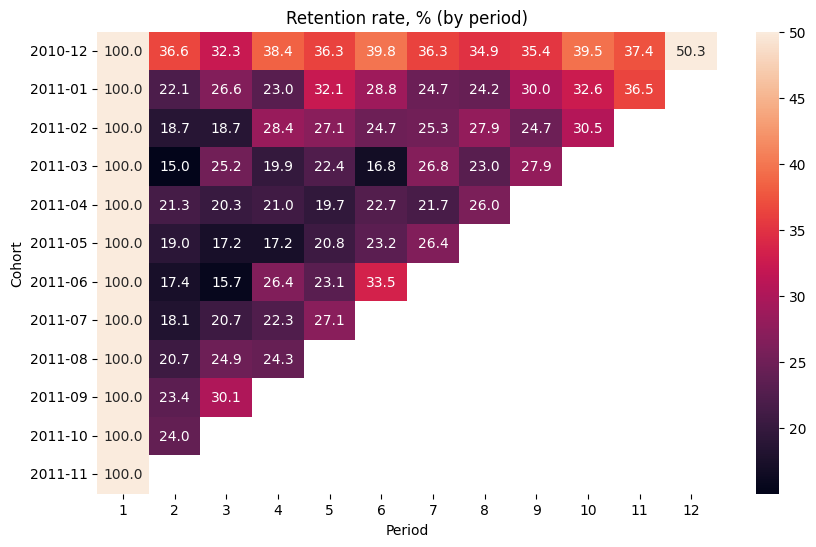

In [ ]:
plt.figure(figsize=(10,6))

sns.heatmap(
    data=retention,
    annot=True,
    fmt='.1f',
    vmax=50
)
plt.title('Retention rate, % (by period)')
plt.show()

Самая сильная когорта: 2010-12-01. Она показывает более высокое удержание, которое не только стабильно держится, но и возрастает до 50.3% на 12-й месяц.

При видно, что происходит быстрое падение после первого месяца: худшие значения в когортах марта, июня и июля 2011 года. Важно улучшать процесс адаптации новых пользователей.

Сделаем визуализацию с привязкой к календарным месяцам, а не относительным периодам. Это поможет увидеть, есть ли влияние сезонности или каких-либо событий на все когорты.

In [ ]:
cohort_month = pd.pivot_table(
    data=df_ret_grouped,
    index='Cohort',
    columns='InvoiceMonth',
    values='CustomerID'
)
cohort_month

InvoiceMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11
Cohort,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0
2011-01,NaN,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0
2011-02,NaN,NaN,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0
2011-03,NaN,NaN,NaN,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0
2011-04,NaN,NaN,NaN,NaN,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0
2011-05,NaN,NaN,NaN,NaN,NaN,284.0,54.0,49.0,49.0,59.0,66.0,75.0
2011-06,NaN,NaN,NaN,NaN,NaN,NaN,242.0,42.0,38.0,64.0,56.0,81.0
2011-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,188.0,34.0,39.0,42.0,51.0
2011-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0,35.0,42.0,41.0


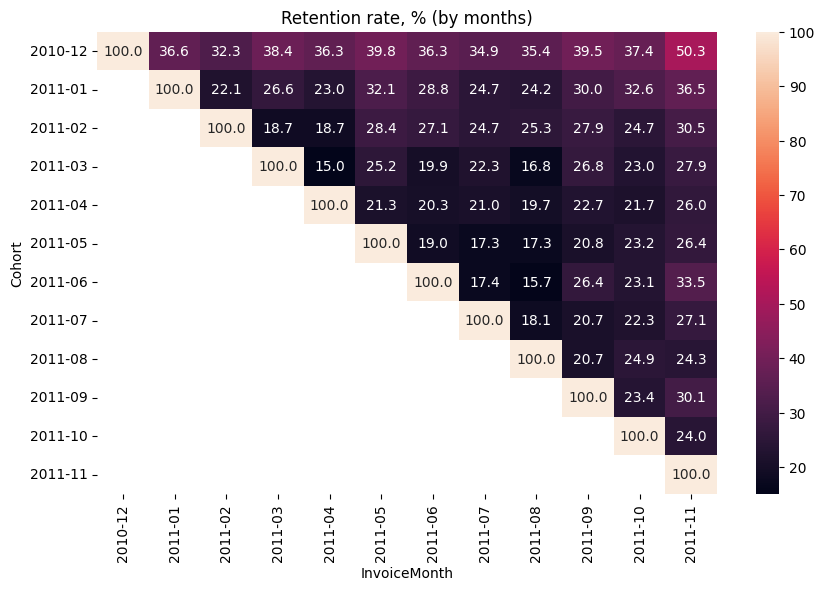

In [ ]:
plt.figure(figsize=(10,6))

sns.heatmap(
    data=cohort_month.div(np.diag(cohort_month), axis=0) * 100,
    annot=True,
    fmt='.1f'
)
plt.title('Retention rate, % (by months)')
plt.show()

Когорта Декабря 2010 года показывает лучшие результаты в течение года. Было бы хорошо подробнее узнать, что происходило и откуда пришли эти пользователи.  
Также можно заметить, что в ноябре 2011 происходил рост активности по всем когортам.  
Весенне-летний период относительно низкое удержание.

Давайте посмотрим, в какой период мы теряем наибольшее количество пользователей. Из предыдущих визуализаций видно, что во второй период отваливается порядка 75%-80% клиентов и это наибольшее значение.  
Убедимся в этом и посмотрим на результаты других периодов.

In [ ]:
churn = cohort_period.pct_change(axis=1, fill_method=None).fillna(0)
churn

Period,1,2,3,4,5,6,7,8,9,10,11,12
Cohort,,,,,,,,,,,,
2010-12,0.0,-0.633898,-0.117284,0.188811,-0.055882,0.096573,-0.088068,-0.037383,0.012945,0.118211,-0.054286,0.344411
2011-01,0.0,-0.779376,0.206522,-0.135135,0.395833,-0.104478,-0.141667,-0.019417,0.237624,0.088000,0.117647,0.000000
2011-02,0.0,-0.813158,0.000000,0.521127,-0.046296,-0.087379,0.021277,0.104167,-0.113208,0.234043,0.000000,0.000000
2011-03,0.0,-0.849558,0.676471,-0.210526,0.122222,-0.247525,0.592105,-0.140496,0.211538,0.000000,0.000000,0.000000
2011-04,0.0,-0.786667,-0.046875,0.032787,-0.063492,0.152542,-0.044118,0.200000,0.000000,0.000000,0.000000,0.000000
2011-05,0.0,-0.809859,-0.092593,0.000000,0.204082,0.118644,0.136364,0.000000,0.000000,0.000000,0.000000,0.000000
2011-06,0.0,-0.826446,-0.095238,0.684211,-0.125000,0.446429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-07,0.0,-0.819149,0.147059,0.076923,0.214286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2011-08,0.0,-0.792899,0.200000,-0.023810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
mask = churn == 0

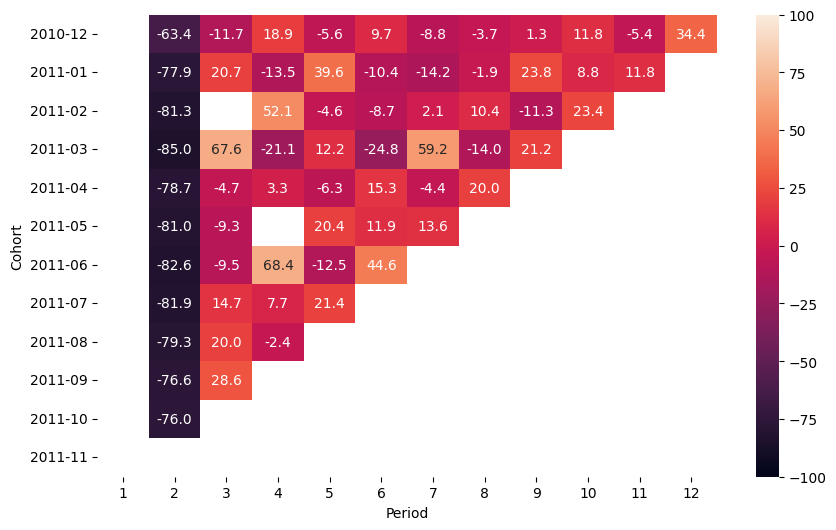

In [ ]:
plt.figure(figsize=(10,6))

sns.heatmap(
    data=churn * 100,
    annot=True,
    fmt='.1f',
    vmin=-100,
    vmax=100,
    mask=mask
)
plt.show()

Наибольший отток во второй период: около 79%.  
Важно улучшать процесс адаптации новых клиентов.

In [ ]:
churn.loc[:, 2].median() * 100

-78.97830374753451

###SQL: retention

Получил идентичный результат с помощью SQL:

In [ ]:
query('''

WITH t0 AS (
  SELECT
    *,
    DATE_TRUNC('month', InvoiceDate) AS InvoiceMonth,
    DATE_TRUNC('month', FIRST_VALUE(InvoiceDate) OVER(PARTITION BY CustomerID ORDER BY InvoiceDate)) AS Cohort
  FROM data
),
cohort_table AS (
  SELECT
    Cohort,
    InvoiceMonth,
    COUNT(DISTINCT CustomerID) AS TotalCustomer,
    FIRST_VALUE(COUNT(DISTINCT CustomerID)) OVER(PARTITION BY Cohort ORDER BY InvoiceMonth) AS CustomerFirstPeriod,
    ROW_NUMBER() OVER(PARTITION BY Cohort ORDER BY InvoiceMonth) AS Period
  FROM t0
  GROUP BY Cohort, InvoiceMonth
  ORDER BY 1, 2
)

SELECT
  Cohort,
  ROUND(SUM(CASE WHEN Period = 1 THEN TotalCustomer * 1.0 / CustomerFirstPeriod  END) * 100, 2) AS '1',
  ROUND(SUM(CASE WHEN Period = 2 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '2',
  ROUND(SUM(CASE WHEN Period = 3 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '3',
  ROUND(SUM(CASE WHEN Period = 4 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '4',
  ROUND(SUM(CASE WHEN Period = 5 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '5',
  ROUND(SUM(CASE WHEN Period = 6 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '6',
  ROUND(SUM(CASE WHEN Period = 7 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '7',
  ROUND(SUM(CASE WHEN Period = 8 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '8',
  ROUND(SUM(CASE WHEN Period = 9 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '9',
  ROUND(SUM(CASE WHEN Period = 10 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '10',
  ROUND(SUM(CASE WHEN Period = 11 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '11',
  ROUND(SUM(CASE WHEN Period = 12 THEN TotalCustomer * 1.0 / CustomerFirstPeriod END) * 100, 2) AS '12',
FROM cohort_table
GROUP BY Cohort
ORDER BY 1



''').to_df()

,Cohort,1,2,3,4,5,6,7,8,9,10,11,12
0,2010-12-01,100.0,36.61,32.32,38.42,36.27,39.77,36.27,34.92,35.37,39.55,37.40,50.28
1,2011-01-01,100.0,22.06,26.62,23.02,32.13,28.78,24.70,24.22,29.98,32.61,36.45,NaN
2,2011-02-01,100.0,18.68,18.68,28.42,27.11,24.74,25.26,27.89,24.74,30.53,NaN,NaN
3,2011-03-01,100.0,15.04,25.22,19.91,22.35,16.81,26.77,23.01,27.88,NaN,NaN,NaN
4,2011-04-01,100.0,21.33,20.33,21.00,19.67,22.67,21.67,26.00,NaN,NaN,NaN,NaN
5,2011-05-01,100.0,19.01,17.25,17.25,20.77,23.24,26.41,NaN,NaN,NaN,NaN,NaN
6,2011-06-01,100.0,17.36,15.70,26.45,23.14,33.47,NaN,NaN,NaN,NaN,NaN,NaN
7,2011-07-01,100.0,18.09,20.74,22.34,27.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2011-08-01,100.0,20.71,24.85,24.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2011-09-01,100.0,23.41,30.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##LTV

In [ ]:
df_ltv = data.copy()
df_ltv.head()

,CustomerID,Revenue,InvoiceDate
0,17850,15.30,2010-12-01 08:26:00
1,17850,20.34,2010-12-01 08:26:00
2,17850,22.00,2010-12-01 08:26:00
3,17850,20.34,2010-12-01 08:26:00
4,17850,20.34,2010-12-01 08:26:00


In [ ]:
df_ltv = df_ltv.groupby(['CustomerID', 'InvoiceDate'], as_index=False)['Revenue'].sum()

In [ ]:
df_ltv['FirstOrder'] = df_ltv.groupby('CustomerID')['InvoiceDate'].transform('min')

Разница в днях между днем первого заказа и всеми заказами пользователя:

In [ ]:
df_ltv['DayDiff'] = (df_ltv['InvoiceDate'] - df_ltv['FirstOrder']).dt.days

In [ ]:
df_ltv['Cohort'] = df_ltv['FirstOrder'].dt.to_period('M')

In [ ]:
df_ltv.head()

,CustomerID,InvoiceDate,Revenue,FirstOrder,DayDiff,Cohort
0,12346,2011-01-18 10:01:00,77183.60,2011-01-18 10:01:00,0,2011-01
1,12347,2010-12-07 14:57:00,711.79,2010-12-07 14:57:00,0,2010-12
2,12347,2011-01-26 14:30:00,475.39,2010-12-07 14:57:00,49,2010-12
3,12347,2011-04-07 10:43:00,636.25,2010-12-07 14:57:00,120,2010-12
4,12347,2011-06-09 13:01:00,382.52,2010-12-07 14:57:00,183,2010-12


Будем считать выручку на пользователя через 30, 60, 90, 180, 300, 400 дней.

Суть следующая: мы будем фильтровать таблицу по выбранным периодам дней относительно первого заказ и считать выручку, заработанную на одного пользователя:

In [ ]:
result = []

In [ ]:
srs = df_ltv[df_ltv['DayDiff'] == 0].groupby('Cohort')['Revenue'].sum() / df_ltv[df_ltv['DayDiff'] == 0].groupby('Cohort')['CustomerID'].nunique()
srs.name = '0'
result.append(srs)
srs

,0
Cohort,
2010-12,449.446271
2011-01,675.644484
2011-02,395.123974
2011-03,421.806350
2011-04,379.644837
2011-05,410.959296
2011-06,545.284587
2011-07,374.612239
2011-08,455.509882


In [ ]:
for i in [30, 60, 90, 180, 300, 400]:
  srs = df_ltv[df_ltv['DayDiff'] <= i].groupby('Cohort')['Revenue'].sum() / df_ltv[df_ltv['DayDiff']<= i].groupby('Cohort')['CustomerID'].nunique()
  srs.name = f'{i}'
  result.append(srs)

In [ ]:
cohort_table = pd.concat(result, axis=1).round(2)
cohort_table

,0,30,60,90,180,300,400
Cohort,,,,,,,
2010-12,449.45,701.76,1006.95,1277.42,2218.18,3851.88,4877.57
2011-01,675.64,745.65,922.40,1063.15,1637.65,2443.66,2629.66
2011-02,395.12,442.42,550.15,660.68,975.34,1531.31,1531.31
2011-03,421.81,478.31,563.09,679.37,981.61,1391.39,1391.39
2011-04,379.64,440.84,540.21,613.72,873.91,1064.64,1064.64
2011-05,410.96,462.53,535.61,604.05,875.17,970.05,970.05
2011-06,545.28,590.22,649.27,710.77,1092.39,1092.39,1092.39
2011-07,374.61,432.60,497.03,583.50,732.38,732.38,732.38
2011-08,455.51,544.13,719.08,1039.18,1067.94,1067.94,1067.94


В строках таблицы (когорты) встречаются повторяющиеся значения выручки - это связано в тем, что с месяца сбора когорты не прошло еще то количество дней, за которое делаем подсчет.  
Уберем эти значения:

In [ ]:
def to_nan(row):
  for i in range(len(row)-1, -1, -1):
    if row[i] == row[i-1]:
      row[i] = np.nan
    else:
      break
  return row

In [ ]:
cohort_table = cohort_table.apply(to_nan, axis=1)
cohort_table

/tmp/ipython-input-43-3437769910.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[i] == row[i-1]:
/tmp/ipython-input-43-3437769910.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  row[i] = np.nan


,0,30,60,90,180,300,400
Cohort,,,,,,,
2010-12,449.45,701.76,1006.95,1277.42,2218.18,3851.88,4877.57
2011-01,675.64,745.65,922.40,1063.15,1637.65,2443.66,2629.66
2011-02,395.12,442.42,550.15,660.68,975.34,1531.31,NaN
2011-03,421.81,478.31,563.09,679.37,981.61,1391.39,NaN
2011-04,379.64,440.84,540.21,613.72,873.91,1064.64,NaN
2011-05,410.96,462.53,535.61,604.05,875.17,970.05,NaN
2011-06,545.28,590.22,649.27,710.77,1092.39,NaN,NaN
2011-07,374.61,432.60,497.03,583.50,732.38,NaN,NaN
2011-08,455.51,544.13,719.08,1039.18,1067.94,NaN,NaN


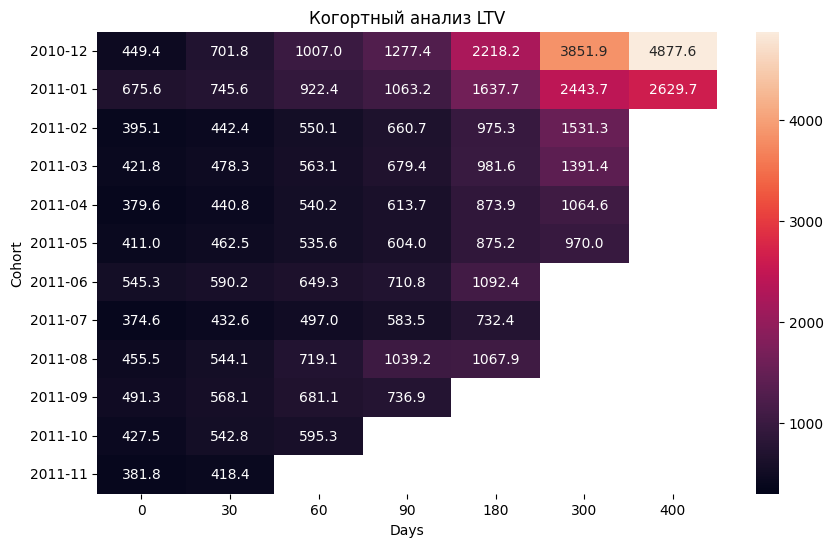

In [ ]:
plt.figure(figsize=(10,6))

sns.heatmap(
    data=cohort_table,
    annot=True,
    fmt='.1f',
    vmin=300
)
plt.title('Когортный анализ LTV')
plt.xlabel('Days')
plt.show()

Когорта декабря 2010 года является лидером по LTV. Когорта января 2011 года тоже показывает хорошие результаты - повод для более подробного их изучения, чтобы адаптировать их опыт для новых когорт и каналов привлечения.  
Весенние когорты показывают слабый старт и медленный рост - возможно, ухудшилось качество трафика или произошли изменения в продукте. У летних и осенних средние результаты.


###SQL: LTV

In [ ]:
query('''

WITH data_cohort AS (
  SELECT
    CustomerID,
    Revenue,
    InvoiceDate,
    FIRST_VALUE(InvoiceDate) OVER(PARTITION BY CustomerID ORDER BY InvoiceDate) AS FirstOrder,
    EXTRACT(DAY FROM
      (InvoiceDate - FIRST_VALUE(InvoiceDate) OVER(PARTITION BY CustomerID ORDER BY InvoiceDate))
    ) AS DayDiff,
    DATE_TRUNC('month',
                FIRST_VALUE(InvoiceDate) OVER(PARTITION BY CustomerID ORDER BY InvoiceDate)
               ) AS Cohort
  FROM (
      SELECT
        CustomerID,
        InvoiceDate,
        SUM(Revenue) AS Revenue
      FROM data
      GROUP BY CustomerID, InvoiceDate
  ) AS t0
),

cohort_table AS (
SELECT
  Cohort,
  ROUND(SUM(CASE WHEN DayDiff = 0 THEN Revenue END) / COUNT(DISTINCT CustomerID), 2) AS "0_day",
  ROUND(SUM(CASE WHEN DayDiff <= 30 THEN Revenue END) / COUNT(DISTINCT CustomerID), 2) AS "30_day",
  ROUND(SUM(CASE WHEN DayDiff <= 60 THEN Revenue END) / COUNT(DISTINCT CustomerID), 2) AS "60_day",
  ROUND(SUM(CASE WHEN DayDiff <= 90 THEN Revenue END) / COUNT(DISTINCT CustomerID), 2) AS "90_day",
  ROUND(SUM(CASE WHEN DayDiff <= 180 THEN Revenue END) / COUNT(DISTINCT CustomerID), 2) AS "180_day",
  ROUND(SUM(CASE WHEN DayDiff <= 300 THEN Revenue END) / COUNT(DISTINCT CustomerID), 2) AS "300_day",
  ROUND(SUM(CASE WHEN DayDiff <= 400 THEN Revenue END) / COUNT(DISTINCT CustomerID), 2) AS "400_day",
FROM data_cohort
GROUP BY Cohort
ORDER BY Cohort
)

SELECT
  Cohort,
  "0_day",
  CASE WHEN "0_day" < "30_day" THEN "30_day" END AS "30_day",
  CASE WHEN "30_day" < "60_day" THEN "60_day" END AS "60_day",
  CASE WHEN "60_day" < "90_day" THEN "90_day" END AS "90_day",
  CASE WHEN "90_day" < "180_day" THEN "180_day" END AS "180_day",
  CASE WHEN "180_day" < "300_day" THEN "300_day" END AS "300_day",
  CASE WHEN "300_day" < "400_day" THEN "400_day" END AS "400_day"
FROM cohort_table

''').to_df()

,Cohort,0_day,30_day,60_day,90_day,180_day,300_day,400_day
0,2010-12-01,449.45,701.76,1006.95,1277.42,2218.18,3851.88,4877.57
1,2011-01-01,675.64,745.65,922.40,1063.15,1637.65,2443.66,2629.66
2,2011-02-01,395.12,442.42,550.15,660.68,975.34,1531.31,NaN
3,2011-03-01,421.81,478.31,563.09,679.37,981.61,1391.39,NaN
4,2011-04-01,379.64,440.84,540.21,613.72,873.91,1064.64,NaN
5,2011-05-01,410.96,462.53,535.61,604.05,875.17,970.05,NaN
6,2011-06-01,545.28,590.22,649.27,710.77,1092.39,NaN,NaN
7,2011-07-01,374.61,432.60,497.03,583.50,732.38,NaN,NaN
8,2011-08-01,455.51,544.13,719.08,1039.18,1067.94,NaN,NaN
9,2011-09-01,491.30,568.09,681.06,736.90,NaN,NaN,NaN
